# DeepLabCut Top-View Zebrafish Data Processing


Note: Please use the conda envirnoment contained in this file directory. It has all the appropriate downloads. Version: Python 3.12.2

In [2]:
import os
import sys
import pathlib

try: # To prevent this section from being run more than once. This is not necessary if you don't use Path.cwd().parent, which can't be run more than once.
    shuffle_dir
except:
    ## Directory containing data (and anything specific to this particular shuffle)
    shuffle_dir = os.path.split(os.getcwd())[-1]
    ## Directory containing packages and videos
    proj_dir = pathlib.Path.cwd().parent
    os.chdir(proj_dir)

print('Current Working Directory: ' + str(pathlib.Path.cwd()))
print('Shuffle Directory: ' + str(shuffle_dir))

from TopViewFishClassification.DLC_processing import feature_extraction, filter, process, uncertainty, video, visualization
import numpy as np

Current Working Directory: /Users/iman/Desktop/Zebrafish Kinematic Classification Pipeline
Shuffle Directory: DLC_Trial3_shuffle1


## Pre-Processing

The following code blocks are responsible for constructing the initial csv file with pose data downloaded from DeepLabCut into a Pandas dataframe that can be used for further data analysis. Two Pandas dataframes are generated from the DLC csv. The first, 'df', contains all of the data from the original csv file, including the confidence the DeepLabCut model had in each point (or the 'likelihood' of each point as it is called in the csv file). No transformations will be applied to this dataframe. The second dataframe, 'pdf', contains position data only which will be used for further transformations. 

In [3]:
csv_files = [shuffle_dir + '/DLC_Data/240523_hcrt-reachr_cFos_1s_1IPI_#6_topview_wholefish_10min_25fps_0DLC_HrnetW32_Top-View ZebrafishJun26shuffle1_detector_200_snapshot_200.csv',
             shuffle_dir + '/DLC_Data/240523_hcrt-reachr_cFos_1s_1IPI_#6_topview_wholefish_10min_25fps_1-2DLC_HrnetW32_Top-View ZebrafishJun26shuffle1_detector_200_snapshot_200.csv']
df, points = process.concatenate_clips(csv_files)
pdf = process.extract_position_data(df)

### Removing Low-Certainty Data
DLC models generate both a prediction for the location of a body part and a value for the model's certainty in that prediction. This value is between 0 and 1. The model's certainty is termed the 'likelihood' of that point. If the likelihood is below a certain value, the model most likely made a outrageously bad guess that will mess up further data processing. Based on playing with the data, I prefer to delete any points below 0.6 certainty (this is the default cut-off for any functions listed below). The default for DeepLabCut is also 0.6. The module uncertainty in the TopViewFishClassification.DLC_Processing package is responsible for replacing low certainty data in order to preserve the continuity of the label trajectories.

#### Interpolation 
Apply interpolation with the uncertainty.interpolate_position_data function. This function will interpolate over any low-certainty data. There are several methods by which to interpolate over missing data. I have set the default method to quadratic spline interpolation (interpolates based off of piece-wise quadratic function fit to the data). For more methods see: https://docs.scipy.org/doc/scipy/reference/interpolate.html and the pd.DataFrame.interpolate documentation

#### Set to Position of Previous Label
Usually when the model has low certainty about a point, it is because that point is occluded by another body part or the area around the point is so blurry that the point has dissapeared from the frame. This is especially true of points along the tail. In a top-view recording of a zebrafish, the lower end of the tail may disappear beneath the rest of the body as the zebrafish flicks its tail under itself or it may blur to the point of appearing to disappear with rapid movements. For this reason, it is sometimes easiest to set the location of the occluded/vanished points to the closest unobscured rostral point on the tail. To apply this method use uncertainty.set_to_prev_point

#### Extend Tail
In this method, low-certainty points are spaced evenly along the line formed by the two closest rostral points of the tail. For rapid movements of the tail, interpolation often performs poorly. Interpolated points may be located inbetween other more rostral point labels on the fish, which makes little logical sense. Inferring the position of an uncertain data point based off of the position of more rostral datapoints in the same frame prevents these logical inconsistencies even if this method results in points that are far off from the ground truth. In contrast to setting the values of uncertain points to a more rostral, unobscured point on the tail, this method does not assume that those points have dissapeared under the body of the zebrafish, which may be better for frames with blurry but not obscured points (Note: I did not end up using this method because set_to_prev_point appeared to make more logical sense when applied to the data). To apply this method use uncertainty.extend_tail

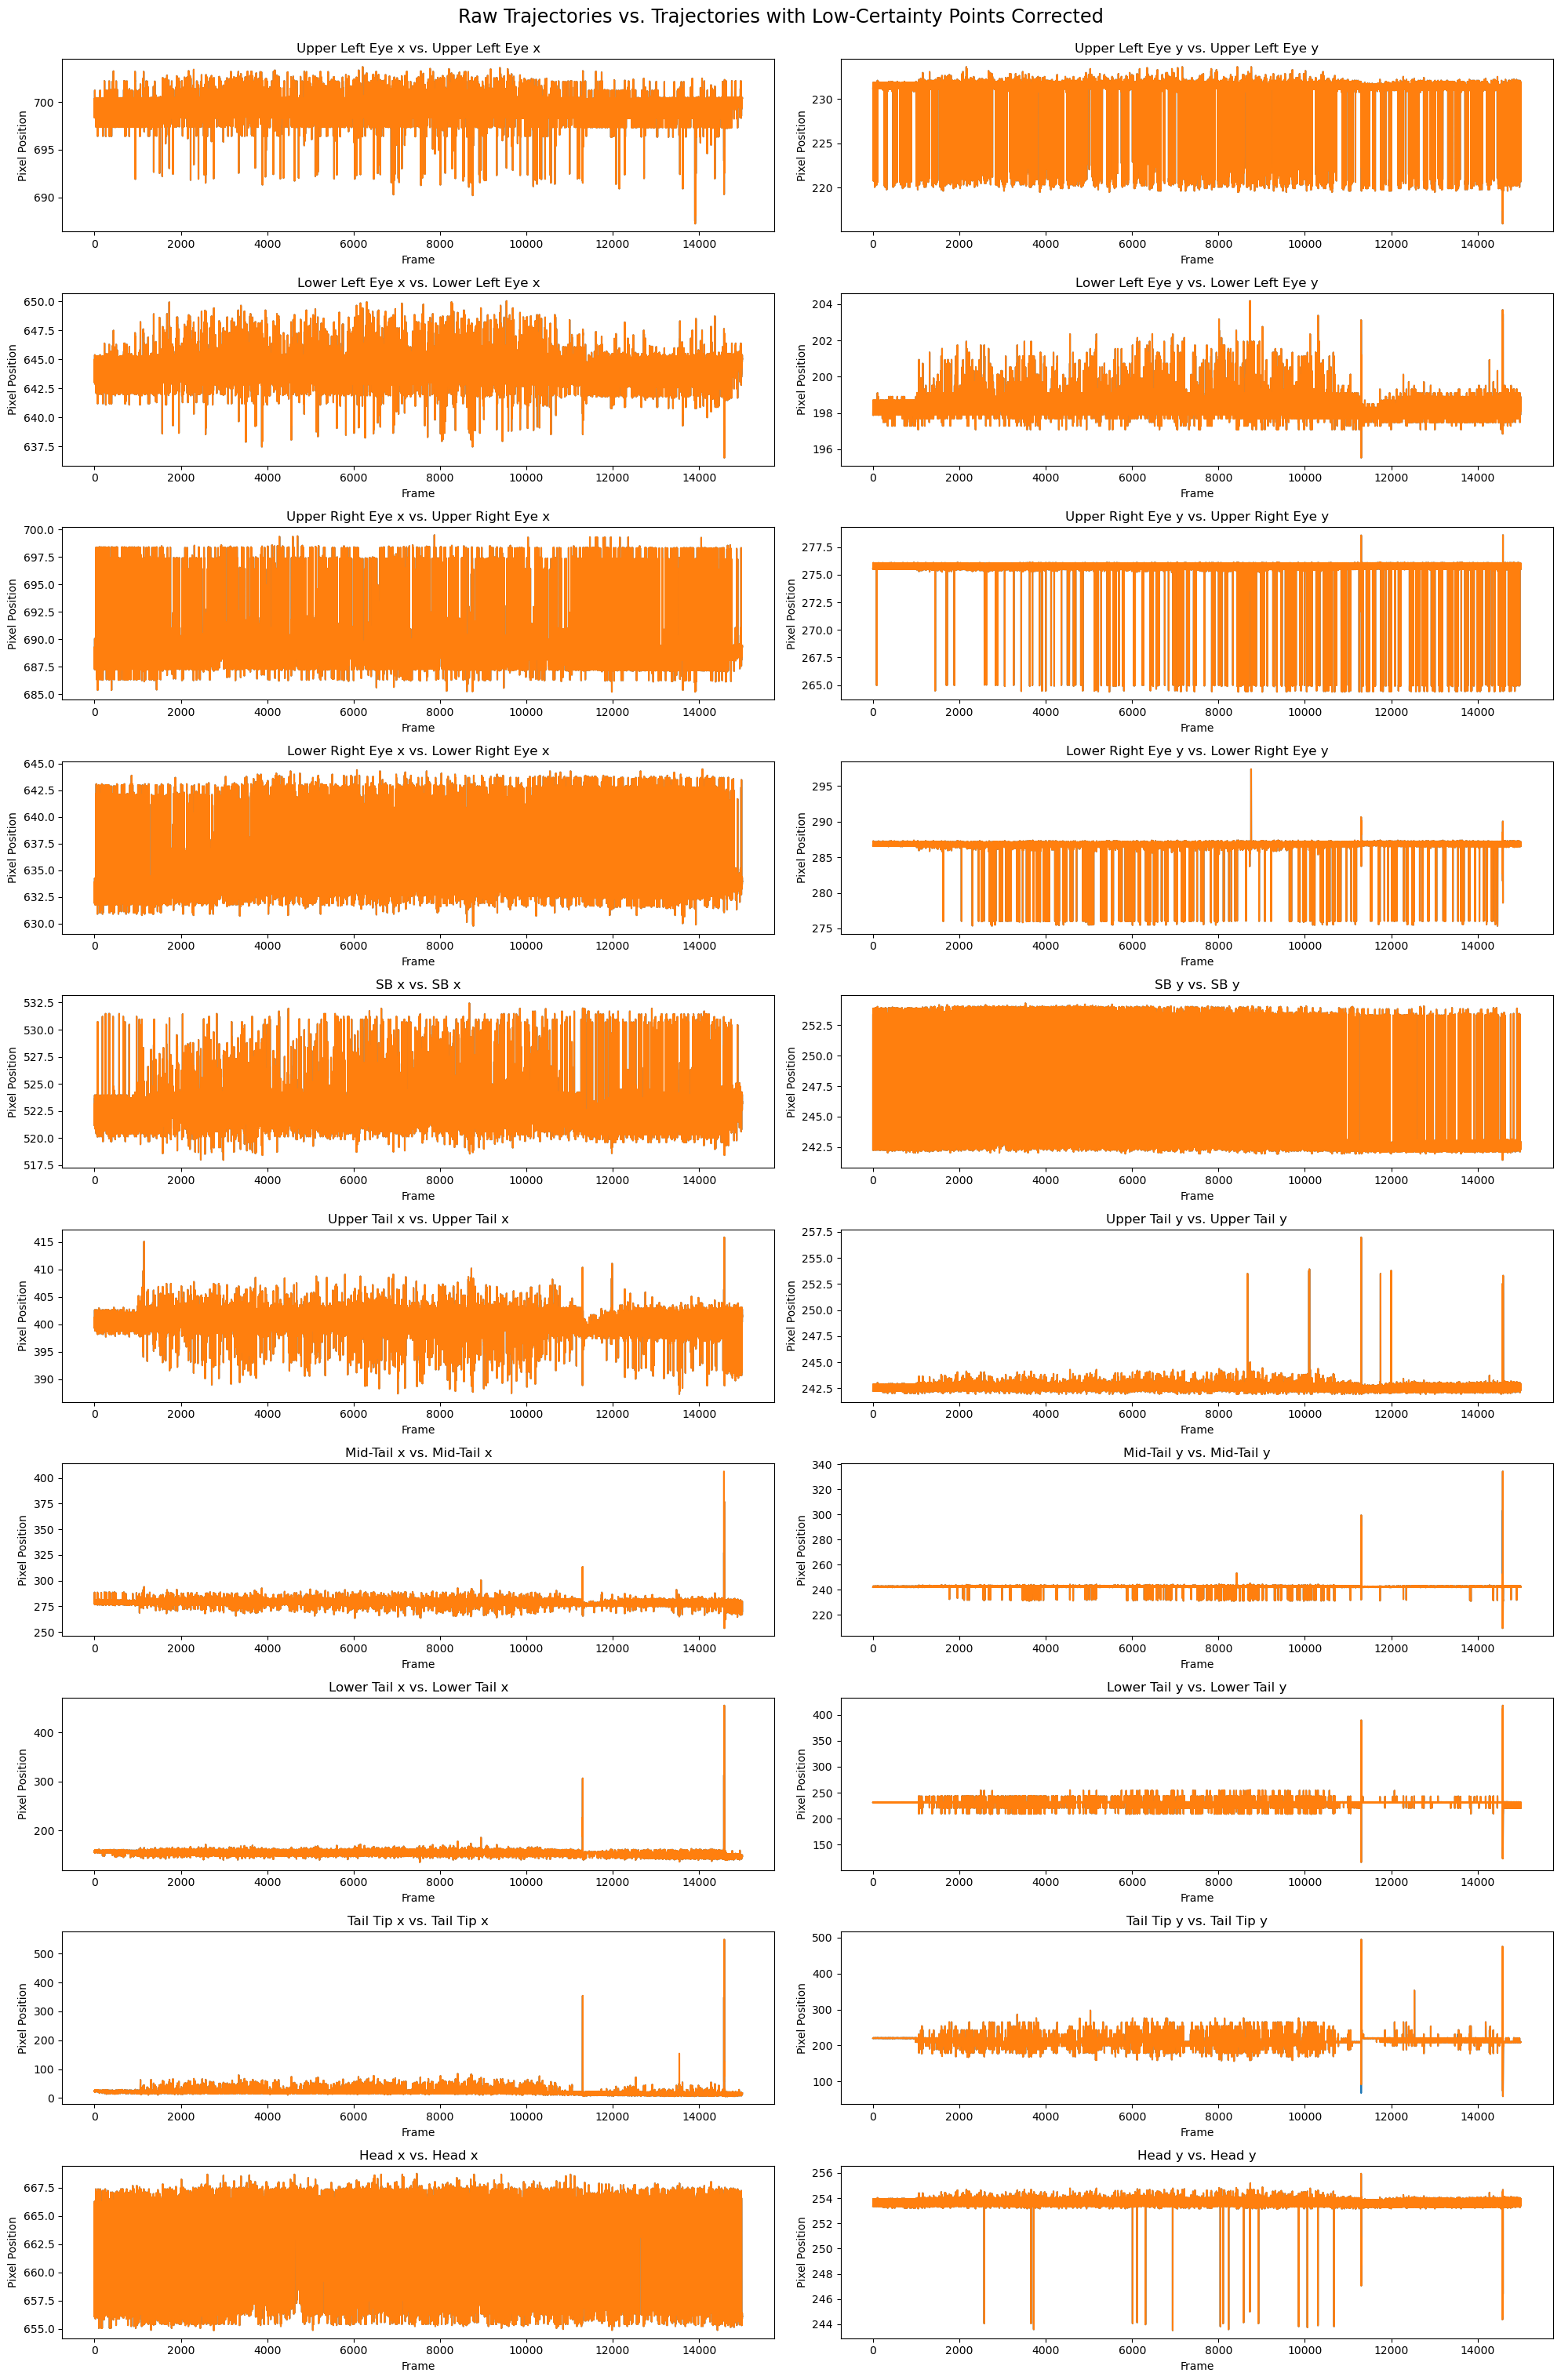

In [4]:
# Interpolate over all columns with the quadratic spline method
interp_pdf = uncertainty.interpolate_position_data(df, pdf, points)

# Set low-certainty tail tip, lower tail, and mid-tail points to the
# values of the closest rostral tail point. This replaces
# any values that were changed by interpolate_position_data
skeleton = ['Tail Tip', 'Lower Tail', 'Mid-Tail', 'Upper Tail'] 
interp_pdf = uncertainty.set_to_prev_point(interp_pdf, df, skeleton)

# Compare transformed dataframe with original
visualization.plot_trajectories([pdf,interp_pdf], df_names = ['Raw Trajectories', 'Trajectories with Low-Certainty Points Corrected'], y_axis = 'Pixel Position')

In [5]:
interp_pdf.to_csv(shuffle_dir + '/Interpolated DLC Data/240523_hcrt-reachr_cFos_1s_1IPI_#6.csv')

### Reducing Noise: Low-Pass Filters
Since the DLC model is trained on human-labelled images, the points which the model generates contain a lot of noise. Simply observing a labelled video one can see that the points appear to jitter around the general location of a body part. In order to apply further machine learning techniques, these micro-movements must be smoothed out to prevent any additional models that are applied from trying to learn from the noise. Each method can be applied with custom settings for each body part.

#### Median Filter
This method smooths out data by setting each value to the median value of itself and the surrounding points. This filter is usually better for preserving data with sudden changes in amplitude. The mean filter will generally significantly reduce sudden changes in amplitude, which is not ideal. This method will be preferred for low resolution videos in which the zebrafish made sudden movements.

#### Mean Filter
Also known as the boxcar filter, this method smooths out data by setting each value to the mean value of itself and the surrounding points.

### Reducing Noise: Custom Filters
Data-processing filters are generally classified into high-pass and low-pass filters which remove low-frequency and high-frequency signals respectively. Filters meant to maximize the signal-to-noise ratio (SNR) are most often low-pass filters since noise tends to fluctuate at high frequencies. These low-pass filteres include mean and median filters. However, because the zebrafish are recorded at a relatively low shutter speed, sudden movements by the zebrafish will be interpeted as high-frequency fluctuations and thus as noise. These jumps in the data are smoothed out by median and boxcar filters, consequently removing information about rapid tail and eye movements. Fortunately, sudden movements by the zebrafish can by differentiated from noise by the strength of the signal. Generally, the faster a tail movement the zebrafish makes, the farther the tail travels. Thus, large deviations from the mean are more likely to be an actual movement made by the zebrafish rather than noise. In addition, some labels, such as those around the eyes, move simultaneously. Such signals can be differentiated from noise by the strength of the cross-correlation between labels. Using these facts, I have generated custom filters to preserve high-frequency data while removing noise.

#### Adaptive Gaussian Filter
This filter runs through the data entry-by-entry, replacing each value with a weighted sum of the value and its neighboring values. The weights for each window are determined by a gaussian curve, and the shape of the gaussian curve for each window is determined the derivate or absolute value over that value. The lower the absolute rate of change or absolute value is over the value, the wider the gaussian curve applied to the window. The widest gaussian curves perform similarly to boxcar filters while the sharpest curves retain much the original value. In this way, large, rapid changes in the data are largely preserved while smaller changes are averaged to reduce noise. 

#### Threshold Filter
This acts as a modification to other filters, such as the mean and median filters. This filter only filters data with a derivative or absolute value below a certain threshold value. As such, this filter preserves large, rapid changes in data by simply not applying transformations to them.

#### Threshold Match Filter
This filter acts similarly to the threshold filter in that it acts as a modification to other filters. Unlike the other filters, this filter takes the label trajectories of two points as arguments. It calculates the correlation of the four corresponding trajectories and then only filters the values with a correlation below a certain threshold value. This works best for labels that move simultaneously (such as the labels on a single eye) since the correlation should be higher for the actual signal than for random noise. 

#### Gaussian Match Filter
This filter acts similarly to the shifting gaussian filter in that the filter runs through the data entry-by-entry, replacing each value with a weighted sum of the value and its neighboring values determined by a gaussian curve. The shape of the gaussian curve is determined by the strength of the correlation between two points. The lower the correlation, the wider the gaussian curve applied to the window. The widest gaussian curves perform similarly to boxcar filters while the sharpest curves retain much the original value. In this way, simealtaneous signals are preserved, while more random, high frequncey data is removed. This works best for labels that move simultaneously since the correlation should be higher for the actual signal than for random noise.

#### Wavelet Filter
This filter makes use of a technique called multiresolution analysis. Using the wavelet transform, mutilresolution analysis decomposes a trajectory into time-localized frequency components. Once decomposed, the values of the highest frequency components, which have absolute values which are below a certain threshold value, can be reduced to the mean of the entire trajectory. The components can then be added back together to reconstruct the trajectory. This method is designed to target only low-amplitude, high-frequency noise while preserving high-amplitude peaks that are likely not to be noise. In practice, this method will still slightly modify the shape of these high-amplitude peaks when the original signal is more accurate than the filtered signal. As such, I have made it an option to restore any values above the threshold value. 
For more information on wavelet filters and multiresolution analysis see:

     - https://www.mathworks.com/help/wavelet/ug/practical-introduction-to-time-frequency-analysis-using-the-continuous-wavelet-transform.html
     - https://www.mathworks.com/help/wavelet/ug/practical-introduction-to-multiresolution-analysis.html
     - https://www.youtube.com/watch?v=jnxqHcObNK4

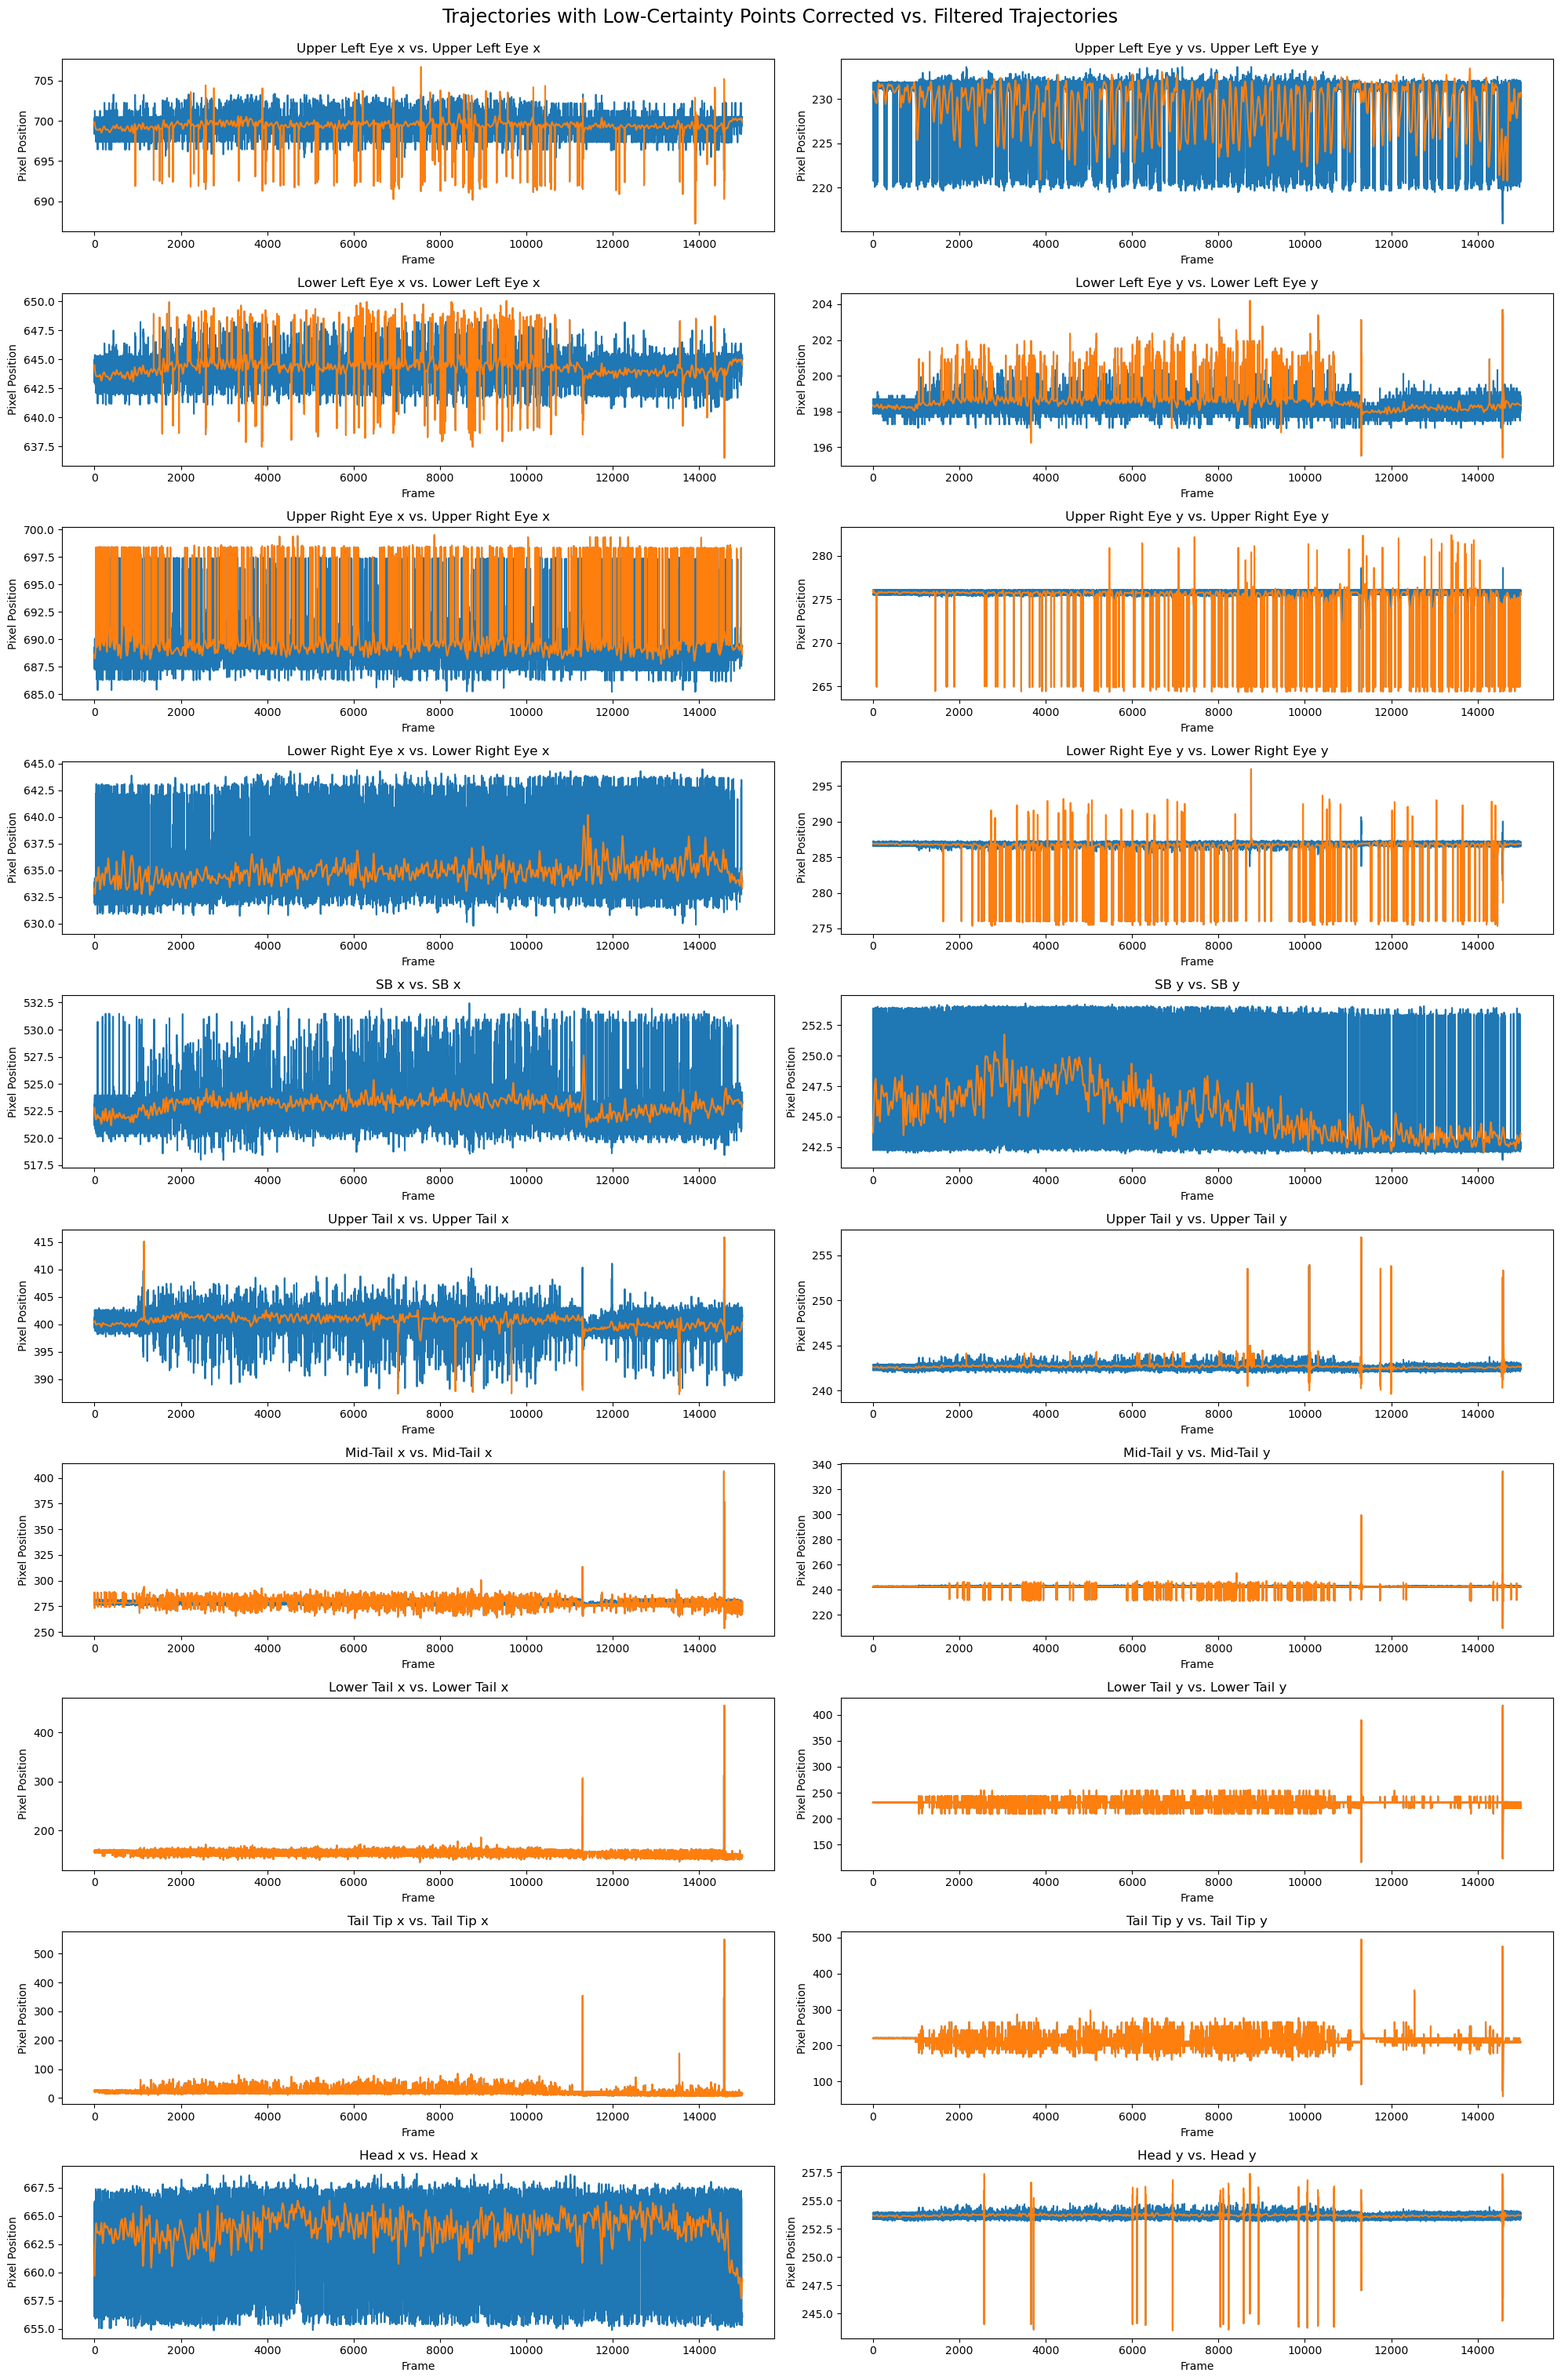

In [6]:
# Set the default threshold
thresh = np.ones(len(interp_pdf.columns)) * 3
# Increase the threshold for mostly stationary points (such as the swim bladder (SB) and the head)
thresh[[8, 10]] = 5
# Reduce the threshold on the lower tail points (these points generally exhibit more movement and less noise)
thresh[[12, 13, 14, 15, 16, 17]] = [1.0, 1.0, 0, 0, 0, 0]

# Apply Filter
filtered_pdf = filter.wavelet_threshold(interp_pdf, np.ones(len(interp_pdf.columns)), thresh)

# Display filtered data vs. the interpolated data
visualization.plot_trajectories([interp_pdf, filtered_pdf], df_names = ['Trajectories with Low-Certainty Points Corrected', 'Filtered Trajectories'], y_axis = 'Pixel Position')

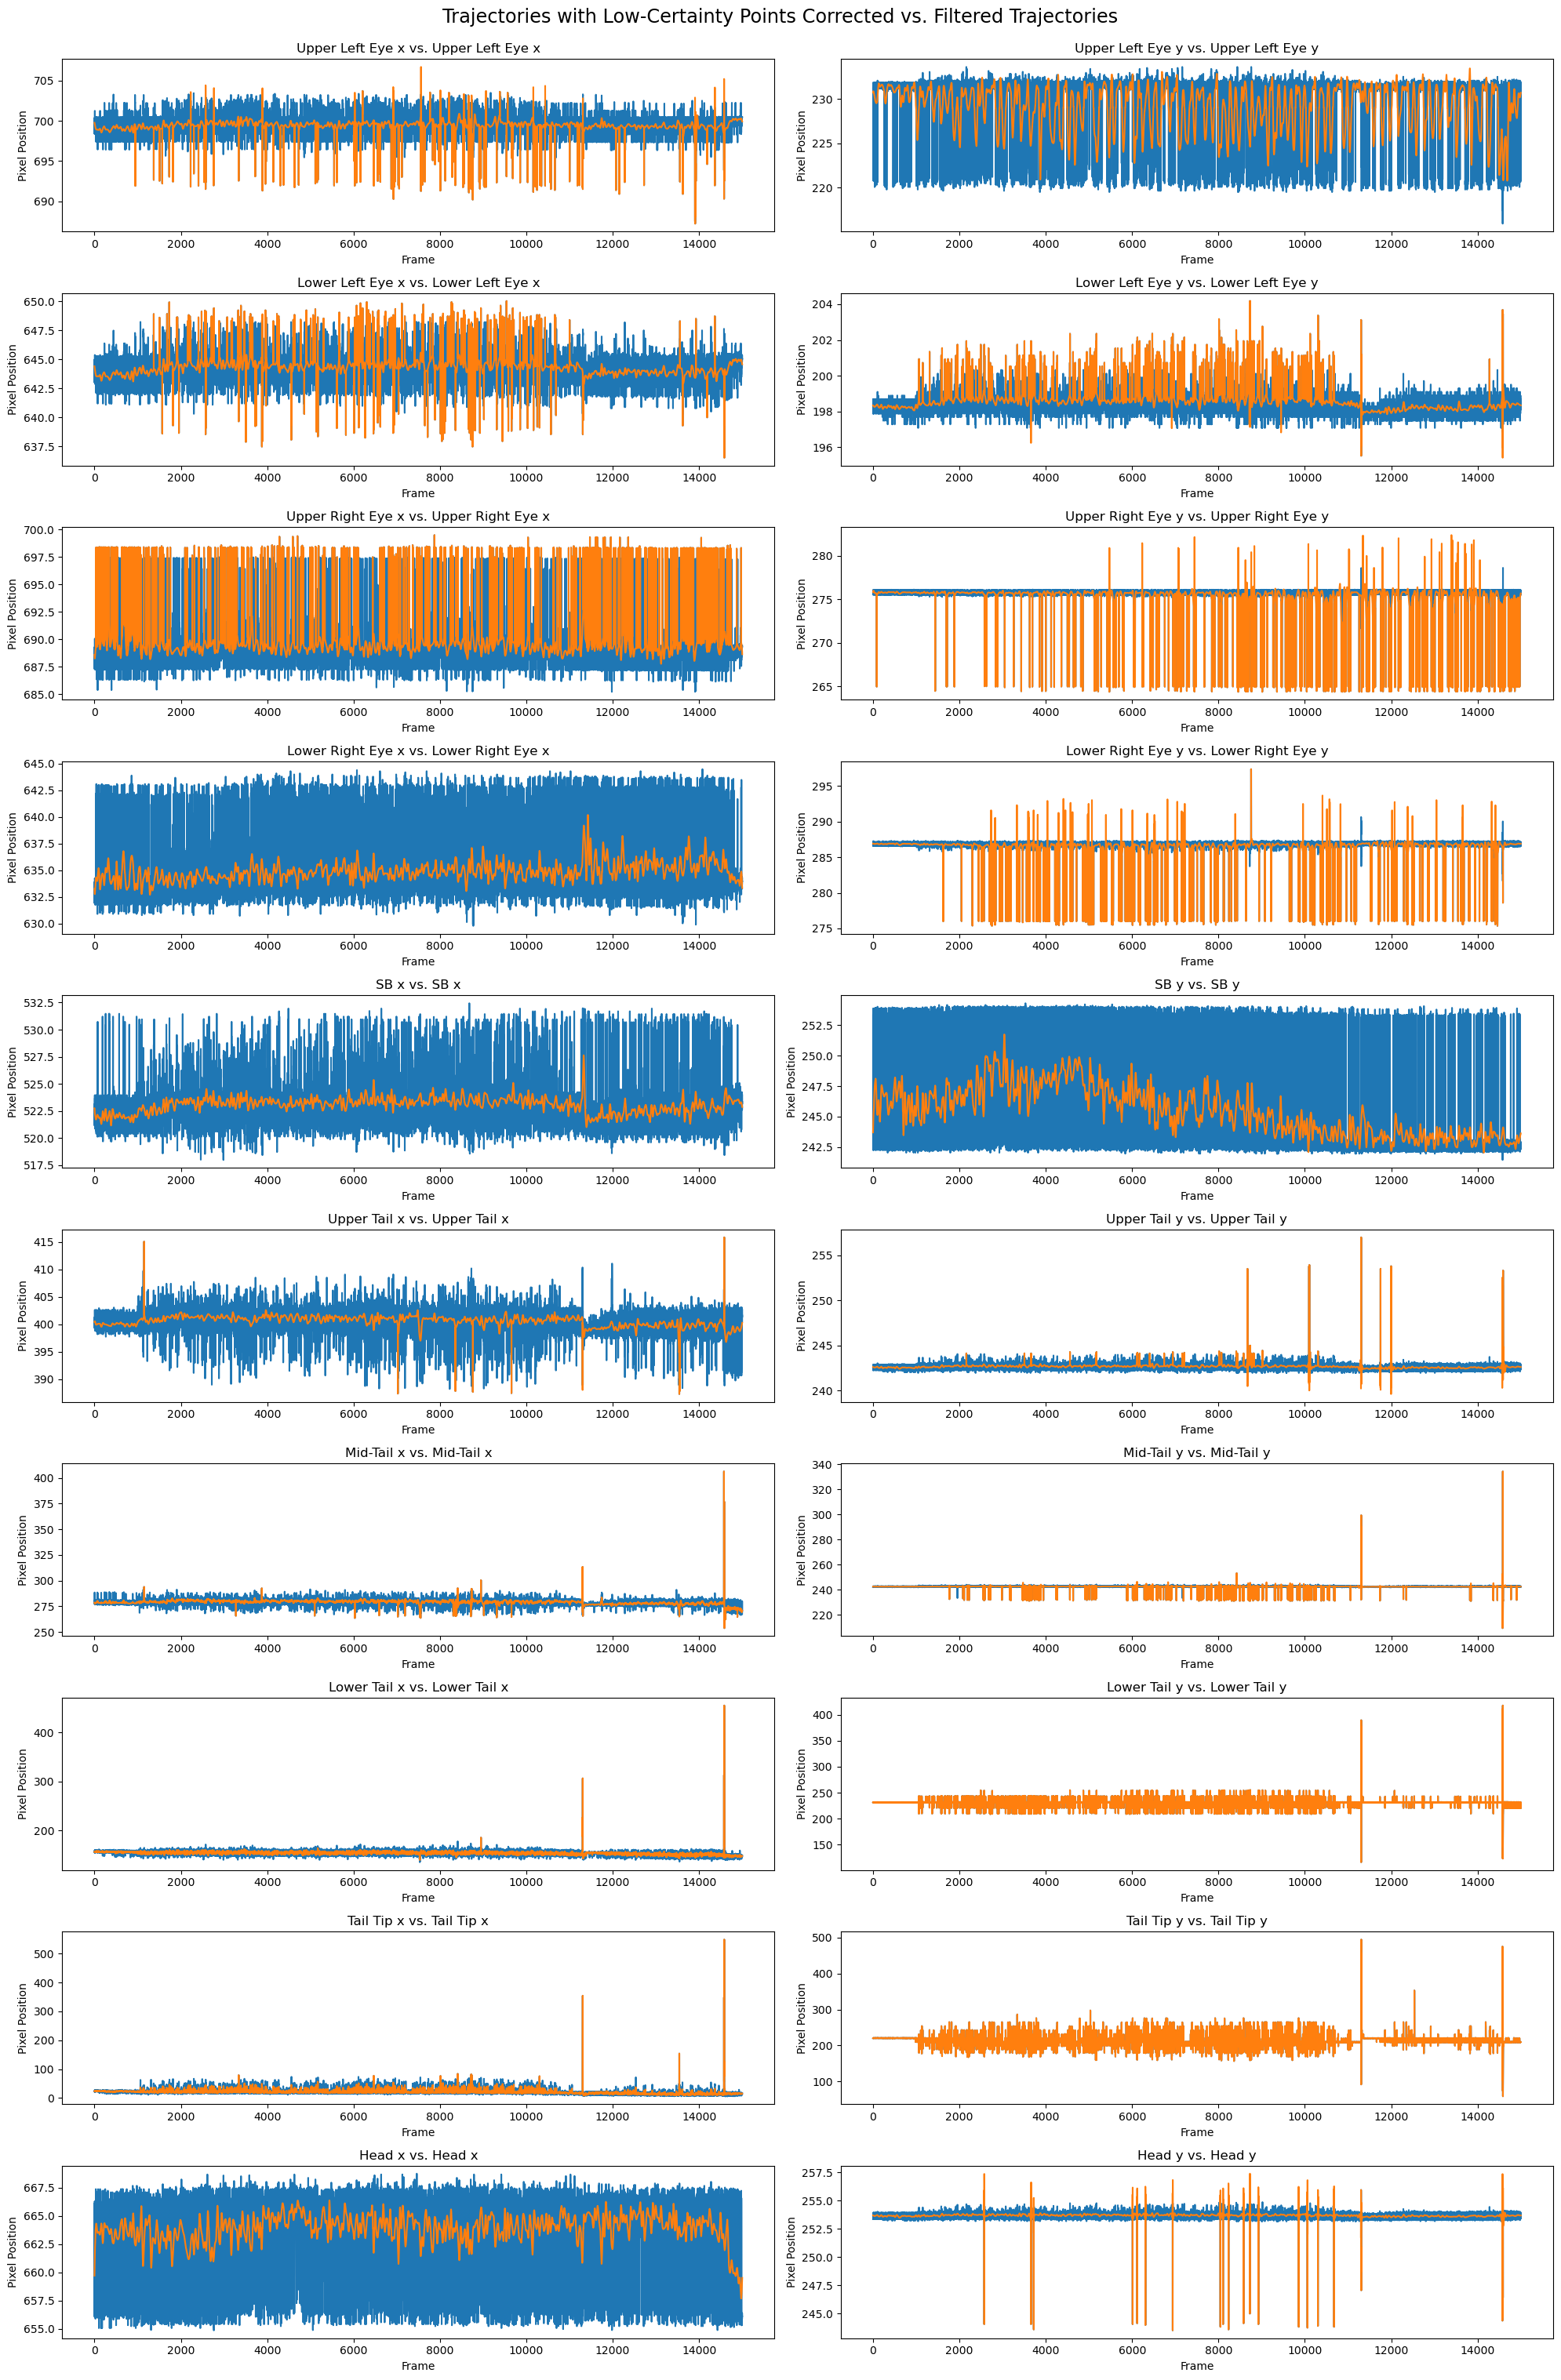

In [7]:
# Smooth out artifacts of wavelet filter with a threshold mean filter
thresh = np.ones(len(interp_pdf.columns)) * 0.1
window = np.ones(len(filtered_pdf.columns)).astype(int) * 13
window[[15,17]] = 0
window[[14, 16]] = 7
filtered_pdf = filter.threshold_filter(filtered_pdf, window, thresh, np.mean, order=0)

# Visualize the filtered data vs. the interpolated data
visualization.plot_trajectories([interp_pdf, filtered_pdf], df_names = ['Trajectories with Low-Certainty Points Corrected', 'Filtered Trajectories'], y_axis = 'Pixel Position')

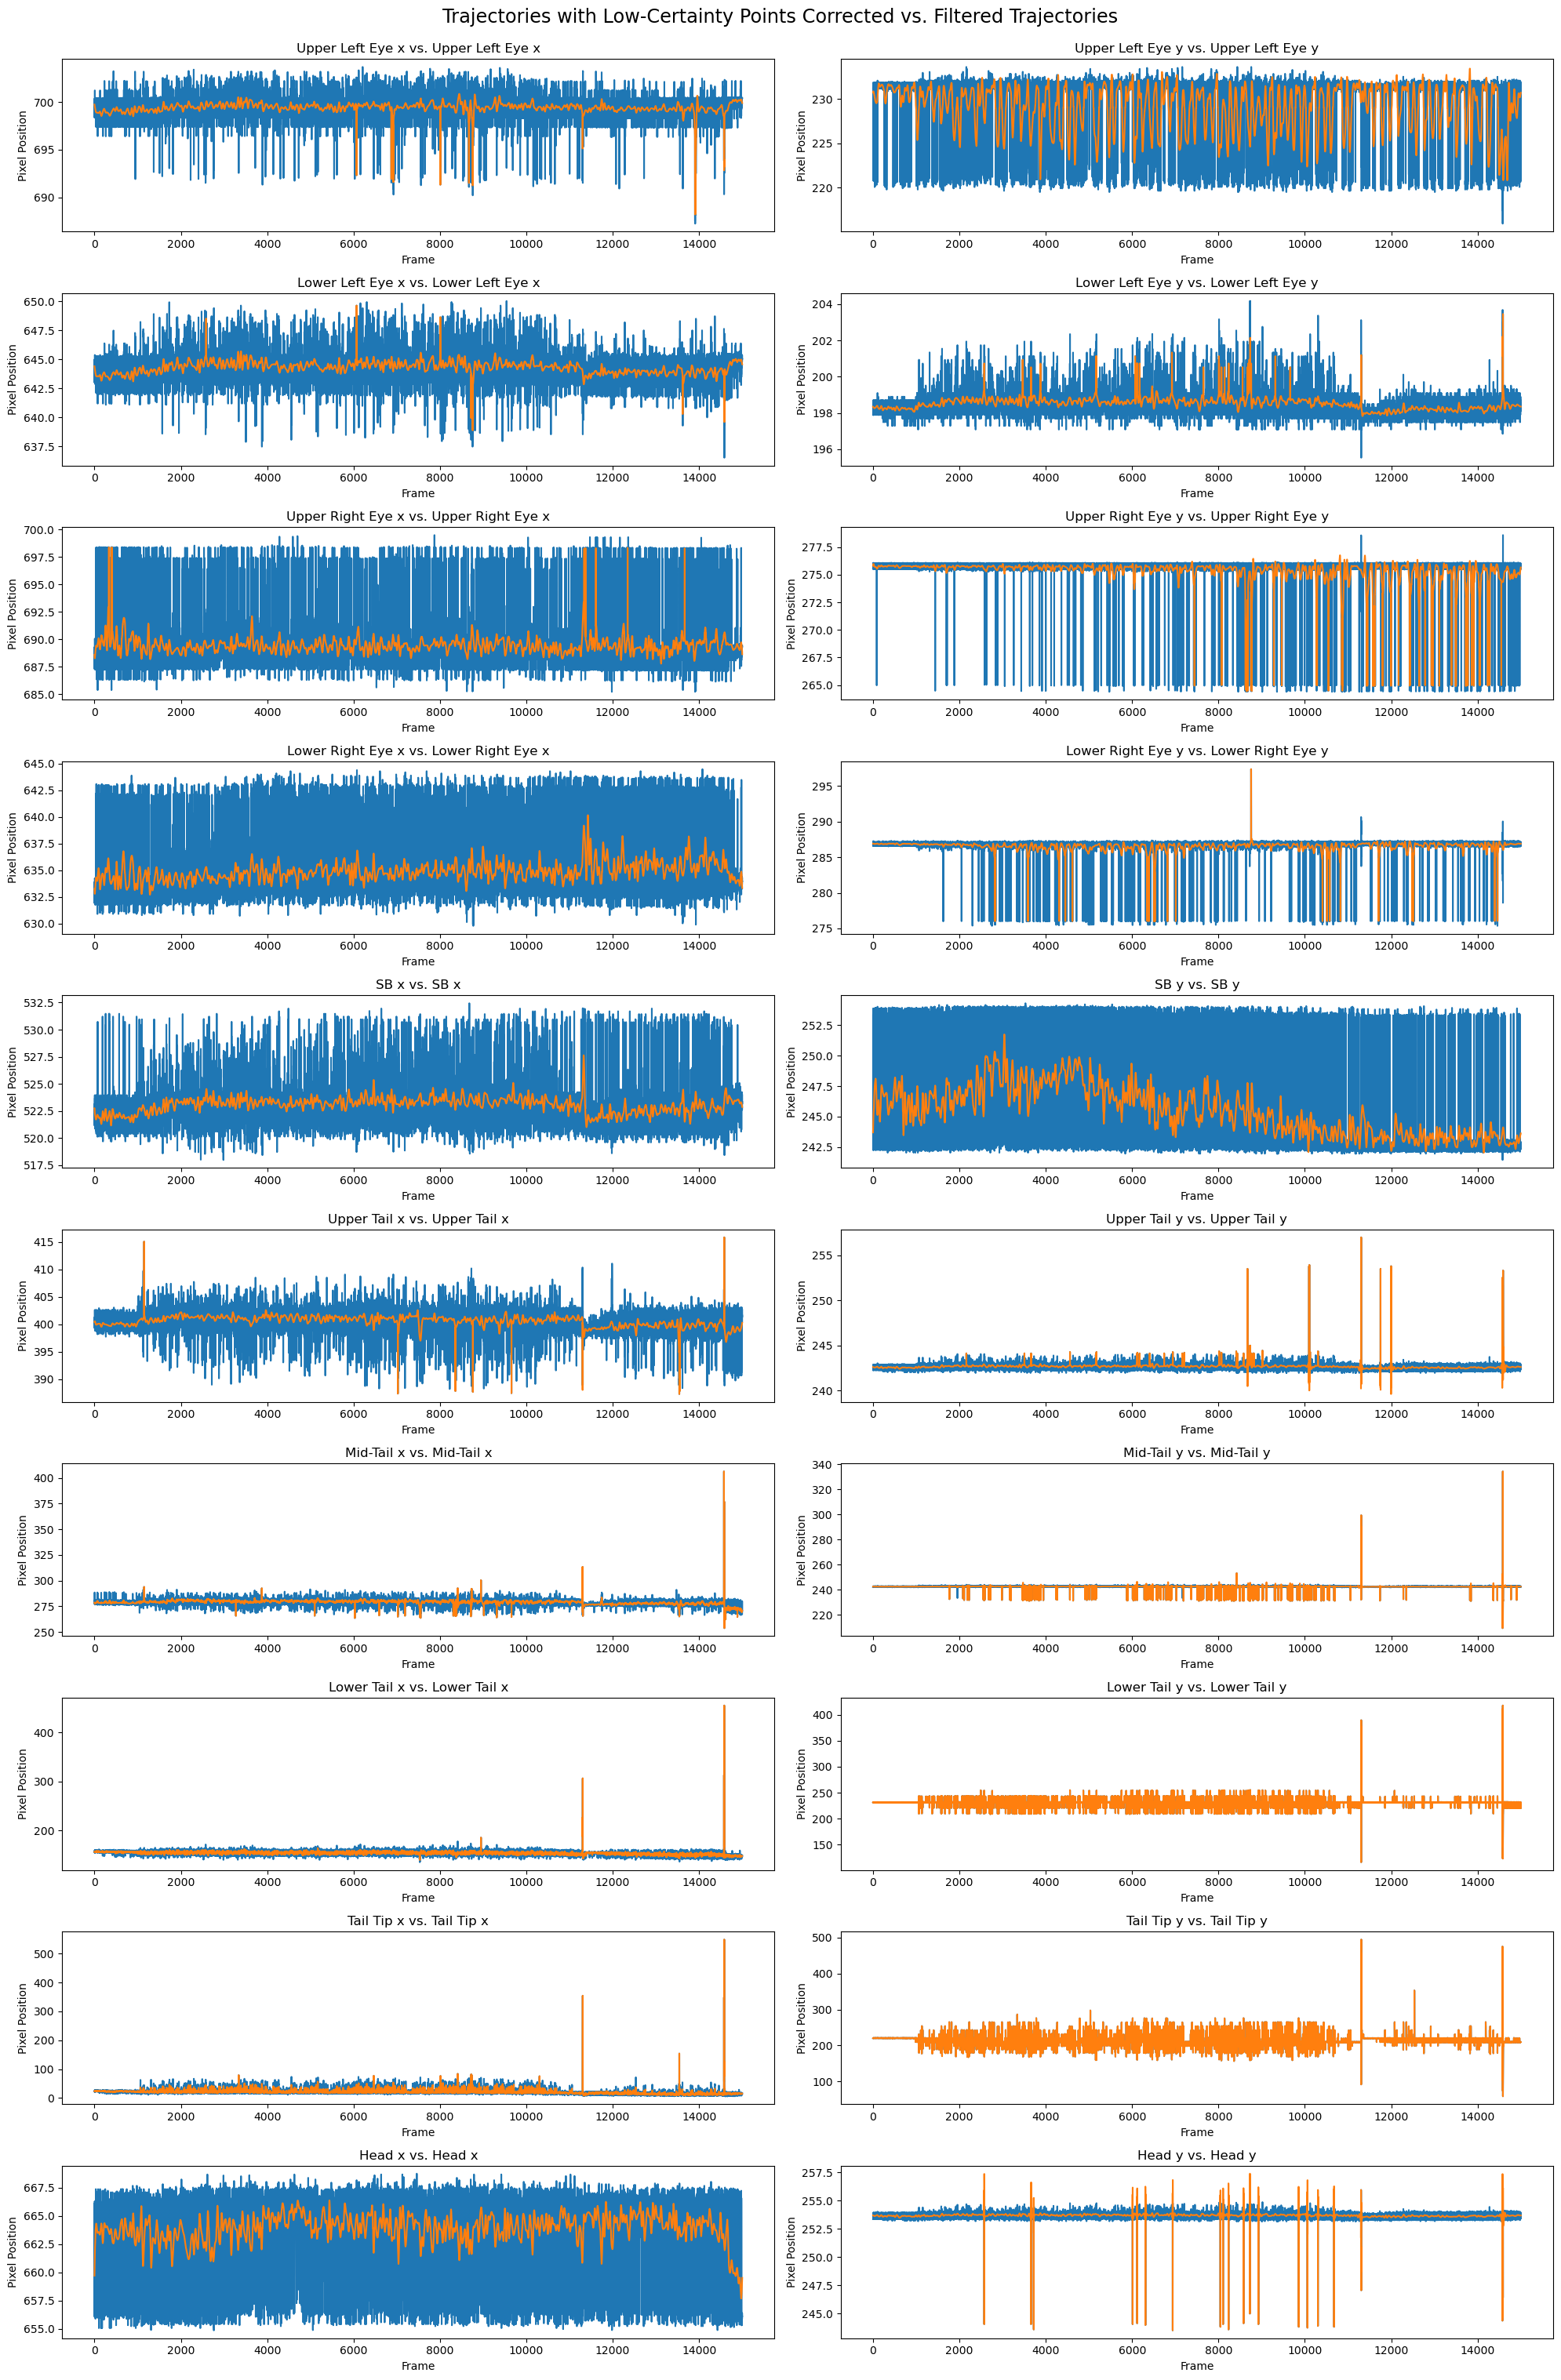

In [8]:
# Filter eye values through threshold match filter in addition to wavelet filter
window = np.ones(len(filtered_pdf.columns)).astype(int) * 5
thresh = np.ones(len(filtered_pdf.columns)) * 0.9
left_filtered = filter.threshold_match_filter(filtered_pdf['Upper Left Eye x'], 
                                       filtered_pdf['Upper Left Eye y'], 
                                       filtered_pdf['Lower Left Eye x'], 
                                       filtered_pdf['Lower Left Eye y'], 
                                       window, thresh, np.median)

window = np.ones(len(filtered_pdf.columns)).astype(int) * 5
thresh = np.ones(len(filtered_pdf.columns)) * 0.9
right_filtered = filter.threshold_match_filter(filtered_pdf['Upper Right Eye x'], 
                                       filtered_pdf['Upper Right Eye y'], 
                                       filtered_pdf['Lower Right Eye x'], 
                                       filtered_pdf['Lower Right Eye y'], 
                                       window, thresh, np.median)
[filtered_pdf['Upper Left Eye x'], filtered_pdf['Upper Left Eye y'], filtered_pdf['Lower Left Eye x'], filtered_pdf['Lower Left Eye y']] = left_filtered
[filtered_pdf['Upper Right Eye x'], filtered_pdf['Upper Right Eye y'], filtered_pdf['Lower Right Eye x'], filtered_pdf['Lower Right Eye y']] = right_filtered
visualization.plot_trajectories([interp_pdf, filtered_pdf], df_names = ['Trajectories with Low-Certainty Points Corrected', 'Filtered Trajectories'], y_axis = 'Pixel Position')

## Visualization
The following blocks will overlay the transformed datapoints onto the original zebrafish recording in order to visualize the changes that have been made to the data.

### Load Zebrafish Recording
The following block of code loads the zebrafish recording into a numpy array that can store any annotations that are made to the images. Change the fish_vid_path variable to the paths of the clips of the video to be annotated 

In [9]:
# Videos to be annotated
fish_vid_paths = ['Videos/240523_hcrt-reachr_cFos_1s_1IPI_#6_topview_wholefish_10min_25fps_0.avi',
                  'Videos/240523_hcrt-reachr_cFos_1s_1IPI_#6_topview_wholefish_10min_25fps_1-2.avi']
frame_list = video.load_video_clips(fish_vid_paths)

Loading Video 2 of 2: 100%|██████████| 9497/9497 [00:37<00:00, 252.14it/s]


### Annotate Recording With Transfomed Data
The following block of code adds annotations to each frame of the zebrafish video. Each frame has text in the bottom-left corner indicating the frame index and is marked with circles representing each bodypart label as indicated by the inputted dataframe. Circles representing points with likelihoods beneath p_cuttoff will be displayed in a different color indicated by error_color. The default is red for low-certainty points and white for high-certainty points.

In [10]:
disp_frame_list = video.annotate_video(filtered_pdf, df, frame_list, points)

Preparing Video for Display: 100%|██████████| 15000/15000 [02:06<00:00, 118.39it/s]


### View Recording with Transformed Data
The following code block opens a GUI for the visualization of the transformed bodypart labels in a zebrafish recording. The GUI has a several buttons that can be used to change the playback speed and direction, quit and pause the video, and step through the video frame by frame.

#### Buttons
    - q : Stops the video and terminates the program
    - up: Increases playback speed 
    - down: Decreases playback speed
    - space: Resumes and pauses the video
    - left: Sets the video to play backward if the video is not paused. If the video is paused, will step backwards through the video frame-by-frame
    - right Sets the video to play forward if the video is not paused. If the video is paused, will step forwards through the video frame-by-frame
    - Stop: Same as Q. Will terminate the program

### Playback Speeds
The video has several playback speeds specified by the python list called speeds. The speed values signify the amount of milliseconds that each frame will be played for. The up and down buttons will step through these speeds in the order given by the list.

### Setting Initial Parameters
The video's starting state can be changed using the paused, s, reverse, and f variables:
   
    - paused: Sets whether video begins paused (True) or playing (False)
    - s: Sets the initial playback speed given the index of a speed in the list speeds
    - reverse: Sets whether video begins playing backwards (True) or forwards (False)
    - f: Sets the first frame to be displayed given the index of that frame
    

In [11]:
video.display(disp_frame_list, f = 0)

## Feature Extraction
In order to perform further analysis on the data generated by DeepLabCut, it is useful to extract only the most salient features so as to reduce the amount of information contained within the data. This will allow for the use of simpler, more efficient machine learning algorithms The features that are extracted in the following code are meant to be invariant to the perspective and position of the fish within the frame of the video. This will make it easier for the pipeline to be later applied to freely moving fish or to fish videos from different recording set-ups.

The current feature extraction function (top_view_extract_features) in the feature extraction module of the TopViewFishClassification.DLC_processing package extracts the angles between adjacent points along the midline of the fish and the angles of the eyes with respect to the midline of the fish. However, I have also written helper functions for extracting the distances between points which can be added to the feature extraction function if needed.


![alt text](image.png)

Figure: Visualization of the two types of extracted features. When calculating the angle of a point along the tail, the vector ending at the point and beginning at the next rostral point (the rostral segment) is used as the axis from which to calculate the angle. The angle is then defined as the angle between the vector from the point to the next caudal point (the caudal segment) and the axis defined by the rostral segment. The angle is zero if the caudal segment has the same orientation as the rostral segment, and postive or negative depending upon if the caudal segment is oriented above or below the axis created by the rostral segment. The eye angle is calculated using the vector pointing from the head point to the swim bladder point as an axis. The eye angle is calcuated according to the angle between the intersection of the line perpendicular to the segment crossing the two eye labels and the axis created by the reference vector.

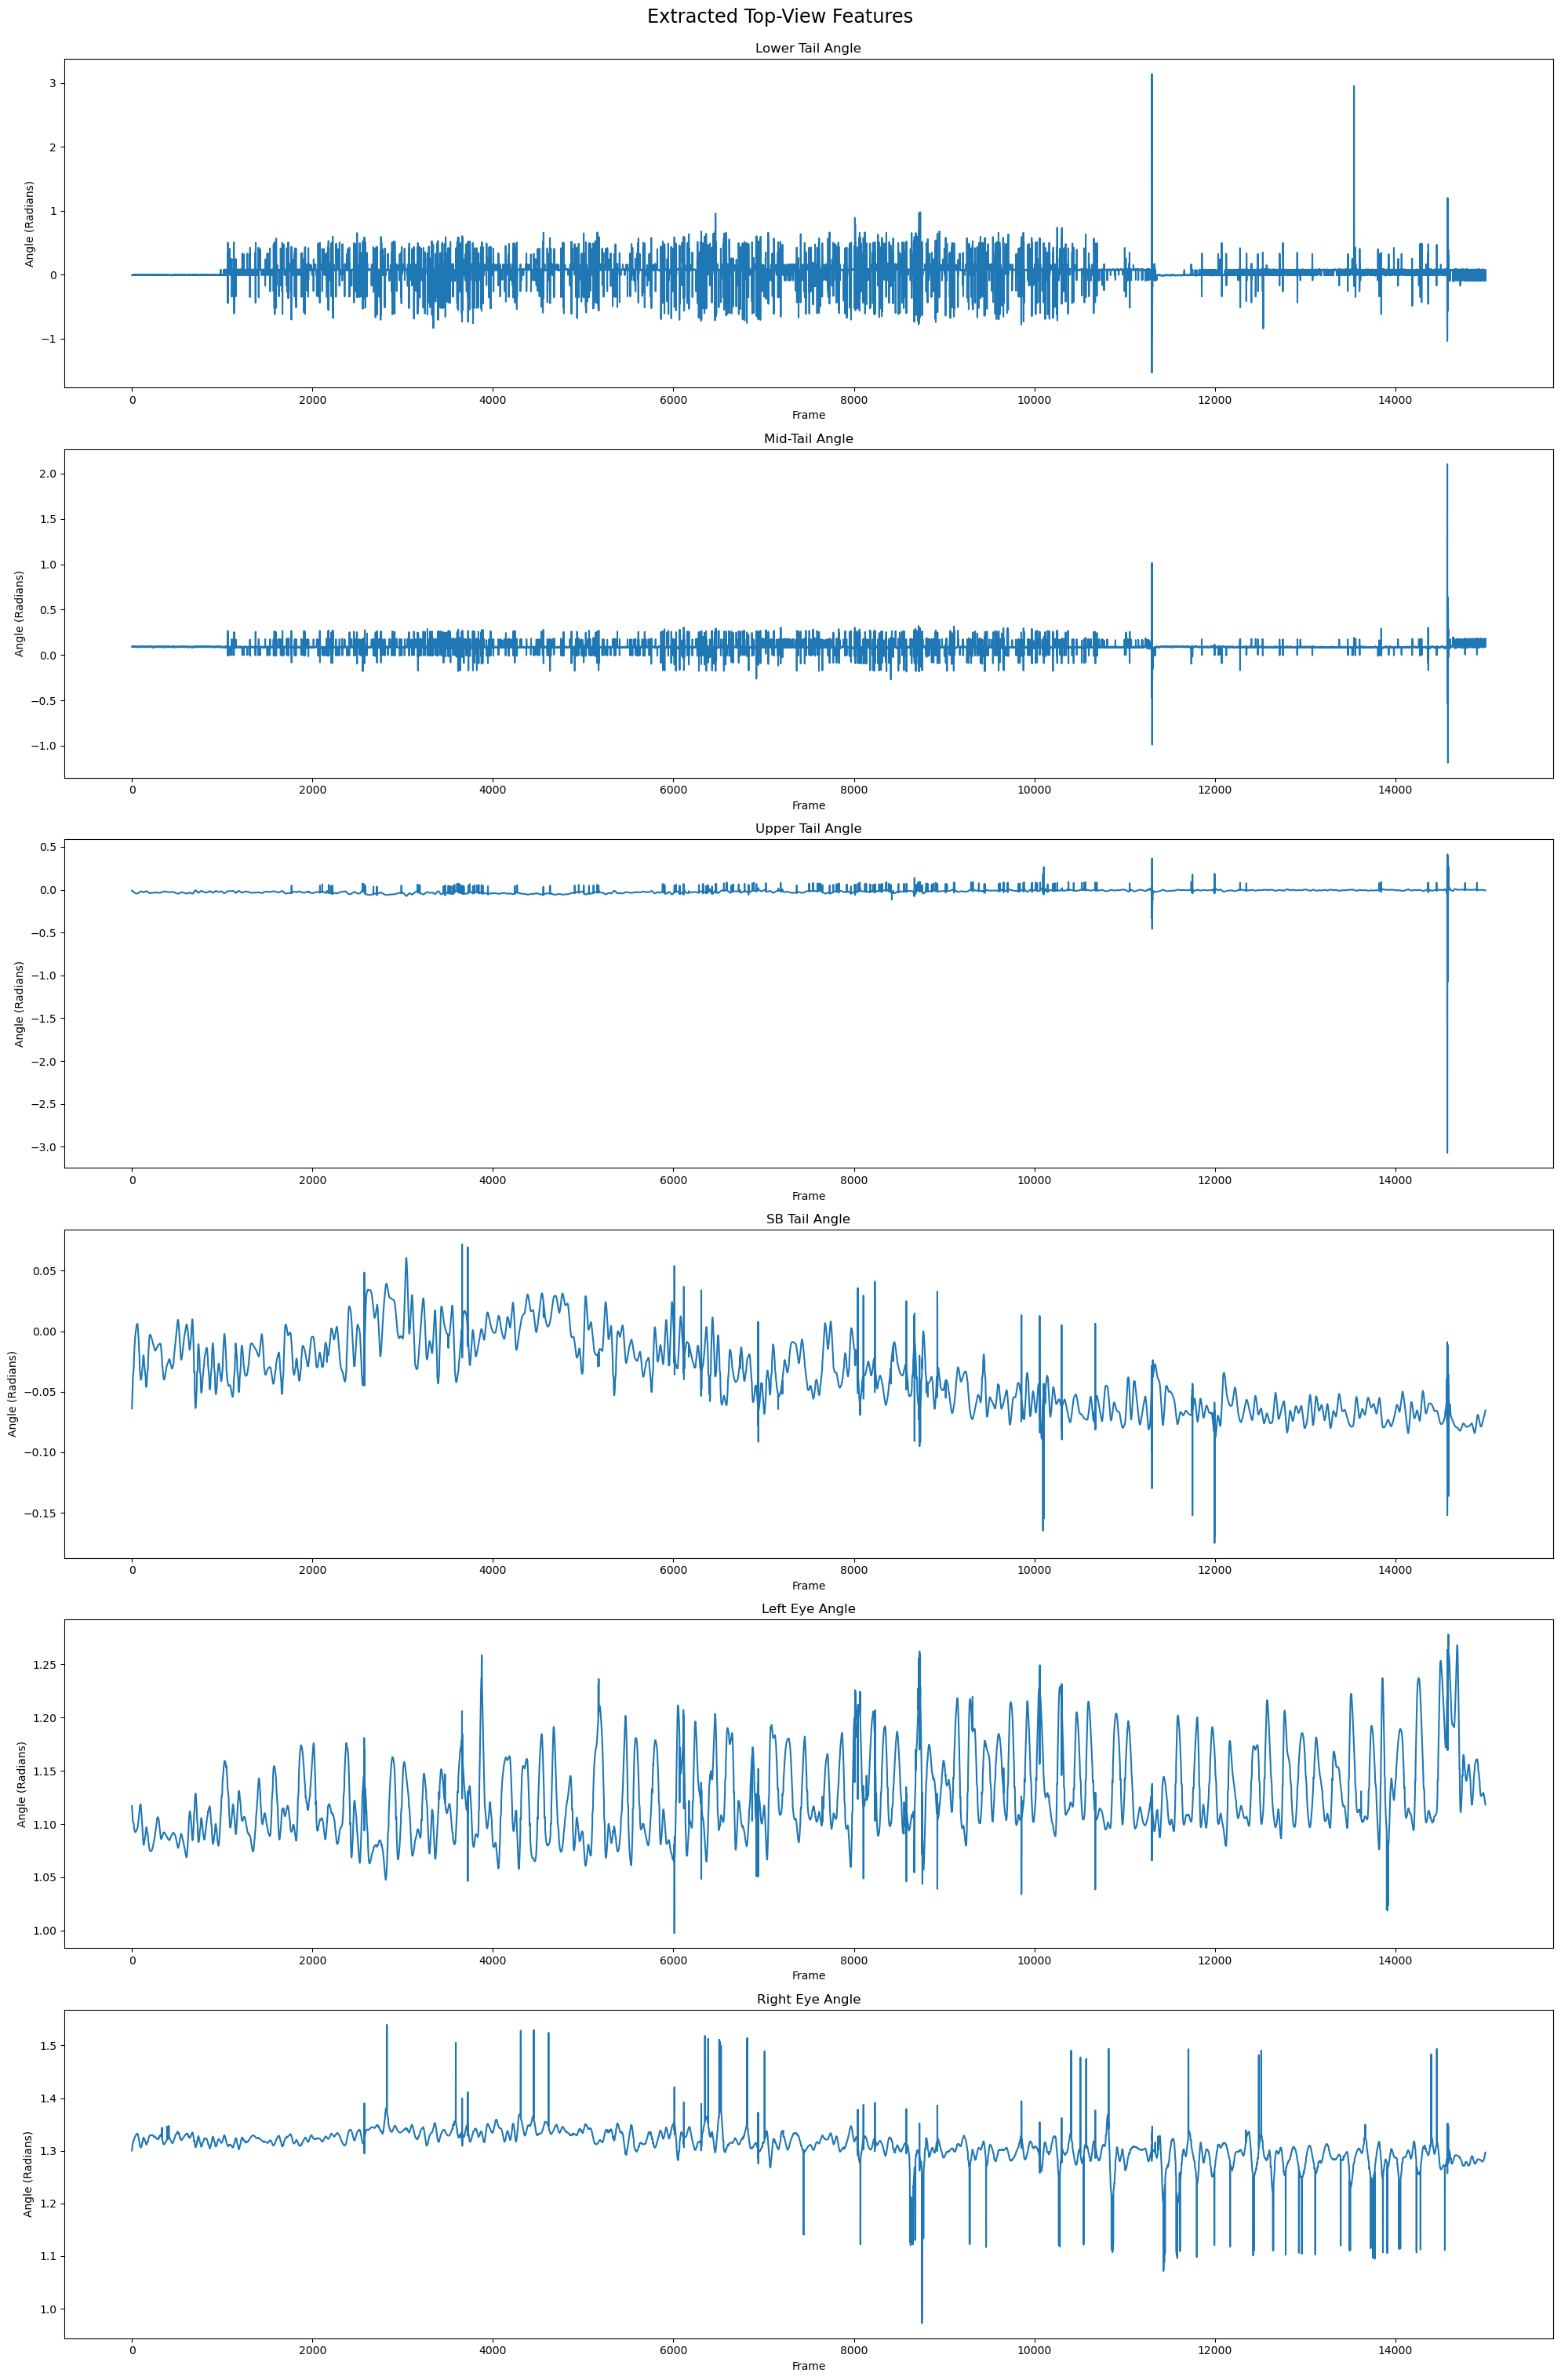

In [12]:
features = feature_extraction.top_view_extract_features(filtered_pdf)
visualization.plot_trajectories([features], ncols=1, df_names = ['Extracted Top-View Features'], y_axis = 'Angle (Radians)')

## Labeling Active and Inactive Frames
The next steps of this pipeline will be focused on differentiating between the different kinematic behaviors of the fish. Using the visualization tool, sections or all of the frames of a zebrafish recording can be separated into two different states: rest or activity (with rest being defined as a frame exhibiting no clear purposeful movement). It is useful to begin classification with only these two broad behavioral classifications for two reasons. First, each series of consecutive frames of activity can define an interval of activity that will receive a single behavioral classification. Second, for many of the recordings, the zebrafish spends the far majority of the frames (tens of thousands of frames) exhibiting no purposeful movement. Collecting these frames into a single "rest" state of the zebrafish that will not be used in further analysis is far more efficient than including them unecessarily.

The eye data is not included in any further classification as it mostly occurs independently of other body movements. Further analysis will be focused on classifying the kinematic maneuvers of the body and tail along the midline of the fish.

In [13]:
# I went through the entire video and separated activity (essentially any significant tail movement) from rest. 
# active_slices contains all the indices of the frames that I labelled as active. 
active_slices = [np.arange(1016, 1023),
                 np.arange(1061, 1070),
                 np.arange(1079, 1086),
                 np.arange(1106, 1115),
                 np.arange(1129, 1139),
                 np.arange(1149, 1157),
                 np.arange(1221, 1229),
                 np.arange(1241, 1245),
                 np.arange(1278, 1283),
                 np.arange(1305, 1319),
                 np.arange(1354, 1360),
                 np.arange(1368, 1377),
                 np.arange(1403, 1409),
                 np.arange(1419, 1424),
                 np.arange(1476, 1482),
                 np.arange(1499, 1503),
                 np.arange(1505, 1512),
                 np.arange(1528, 1535),
                 np.arange(1569, 1575),
                 np.arange(1577, 1589),
                 np.arange(1597, 1605),
                 np.arange(1629, 1633),
                 np.arange(1647, 1653),
                 np.arange(1665, 1673),
                 np.arange(1678, 1690),
                 np.arange(1715, 1724),
                 np.arange(1731, 1745),
                 np.arange(1764, 1773),
                 np.arange(1784, 1787),
                 np.arange(1801, 1810),
                 np.arange(1816, 1822),
                 np.arange(1875, 1879),
                 np.arange(1886, 1893),
                 np.arange(1917, 1923),
                 np.arange(1953, 1961),
                 np.arange(1983, 1988),
                 np.arange(1996, 2000),
                 np.arange(2012, 2018),
                 np.arange(2049, 2052),
                 np.arange(2063, 2070),
                 np.arange(2081, 2088),
                 np.arange(2108, 2114),
                 np.arange(2128, 2133),
                 np.arange(2144, 2148),
                 np.arange(2155, 2165),
                 np.arange(2173, 2184),
                 np.arange(2207, 2218),
                 np.arange(2221, 2232),
                 np.arange(2261, 2268),
                 np.arange(2284, 2289),
                 np.arange(2298, 2305),
                 np.arange(2330, 2337),
                 np.arange(2357, 2363),
                 np.arange(2380, 2384),
                 np.arange(2392, 2398),
                 np.arange(2407, 2416),
                 np.arange(2434, 2438),
                 np.arange(2459, 2469),
                 np.arange(2478, 2488),
                 np.arange(2494, 2500),
                 np.arange(2521, 2529),
                 np.arange(2539, 2544),
                 np.arange(2554, 2566),
                 np.arange(2572, 2489),
                 np.arange(2604, 2609),
                 np.arange(2655, 2660),
                 np.arange(2673, 2681),
                 np.arange(2697, 2702),
                 np.arange(2709, 2721),
                 np.arange(2740, 2746),
                 np.arange(2753, 2768),
                 np.arange(2781, 2791),
                 np.arange(2801, 2810),
                 np.arange(2837, 2841),
                 np.arange(2864, 2869),
                 np.arange(2877, 2894),
                 np.arange(2899, 2907),
                 np.arange(2910, 2919),
                 np.arange(2933, 2939),
                 np.arange(2966, 2972),
                 np.arange(2983, 2993),
                 np.arange(3020, 3029),
                 np.arange(3055, 3059),
                 np.arange(3067, 3077),
                 np.arange(3013, 3109),
                 np.arange(3123, 3129),
                 np.arange(3147, 3150),
                 np.arange(3163, 3175),
                 np.arange(3187, 3193),
                 np.arange(3204, 3209),
                 np.arange(3229, 3234),
                 np.arange(3245, 3252),
                 np.arange(3274, 3281),
                 np.arange(3287, 3295),
                 np.arange(3304, 3309),
                 np.arange(3319, 3333),
                 np.arange(3337, 3346),
                 np.arange(3204, 3208),
                 np.arange(3229, 3234),
                 np.arange(3245, 3256),
                 np.arange(3274, 3281),
                 np.arange(3287, 3295),
                 np.arange(3304, 3308),
                 np.arange(3319, 3333),
                 np.arange(3338, 3347),
                 np.arange(3363, 3369),
                 np.arange(3379, 3398),
                 np.arange(3417, 3423),
                 np.arange(3437, 3443),
                 np.arange(3453, 3459),
                 np.arange(3464, 3480),
                 np.arange(3493, 3498),
                 np.arange(3504, 3511),
                 np.arange(3522, 3535),
                 np.arange(3557, 3562),
                 np.arange(3590, 3595),
                 np.arange(3601, 3624),
                 np.arange(3638, 3643),
                 np.arange(3655, 3670),
                 np.arange(3692, 3697),
                 np.arange(3705, 3712),
                 np.arange(3721, 3732),
                 np.arange(3742, 3751),
                 np.arange(3777, 3783),
                 np.arange(3796, 3802),
                 np.arange(3821, 3830),
                 np.arange(3840, 3846),
                 np.arange(3868, 3882),
                 np.arange(3887, 3894),
                 np.arange(3928, 3937),
                 np.arange(3957, 3965),
                 np.arange(3972, 3980),
                 np.arange(10999, 11005),
                 np.arange(11014, 11025),
                 np.arange(11047, 11052),
                 np.arange(11054, 11061),
                 np.arange(11301, 11323),
                 np.arange(14504, 14507),
                 np.arange(14575, 14601)]

# The indices of the frames that were labelled as either a rest or active frame
labelled_slices = [np.arange(0,4000), np.arange(10995, 11495), np.arange(14500, 15000)]

active_frames = np.array([]).astype(int)
for slice in active_slices:
    active_frames = np.append(active_frames, slice)

labelled_frames = np.array([]).astype(int)
for slice in labelled_slices:
    labelled_frames = np.append(labelled_frames, slice)

# Creates dataframe with data to be used for further analysis (the eyes data is dropped at this point)
tree_df = features.assign(Active = np.ones(features.shape[0]).astype(int))*-1
tree_df = tree_df.drop(['Left Eye Angle', 'Right Eye Angle'], axis=1)
tree_df['Active'].values[labelled_frames] = 0
tree_df['Active'].values[active_frames] = 1

## Save Extracted Features with Active/Inactive Labels for Further Analysis

In [14]:
# Saves the extracted features for each frame and whether or not that frame is labelled as active or rest or unlabelled in a Pandas DataFrame
tree_df.to_csv(shuffle_dir + '/Extracted Features/240523_hcrt-reachr_cFos_1s_1IPI_#6.csv')